# Project Description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. 

We have access to historical data including technical specifications, trim versions, and prices. 

Now, we need to build the model to determine the value. 

Rusty Bargain is interested in:
- The quality of the prediction.
- The speed of the prediction.
- The time required for training.

# Data Overview

**Features**
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user

**Target**
- Price — price (Euro)

# Project Process

1. Explore the data and address missing values, outliers, and other data issues.
2. Perform data preprocessing.
3. Split the data into training and test sets.
4. Train different models (with various hyperparameters) including Linear Regression, Random Forest Regressor, CatBoost Regressor, XGBoost, and LightGBM models.
5. Compare the models' performance and select the best one.
5. Evaluate the best model on the test set.


# EDA and Data Cleaning

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import optuna
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb

In [2]:
# import the csv file into a dataframe and import date fields as datetime
df = pd.read_csv('car_data.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], dayfirst=True)


In [3]:
# convert column names to lowercase
df.columns = df.columns.str.lower()

In [4]:
# preview the data
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


In [5]:
# get information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   mileage            354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  notrepaired        283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

There are many missing values for fueltype, notrepaired, model, gearbox, and vehicletype. Let's examine them and see if it makes sense to fill them in.

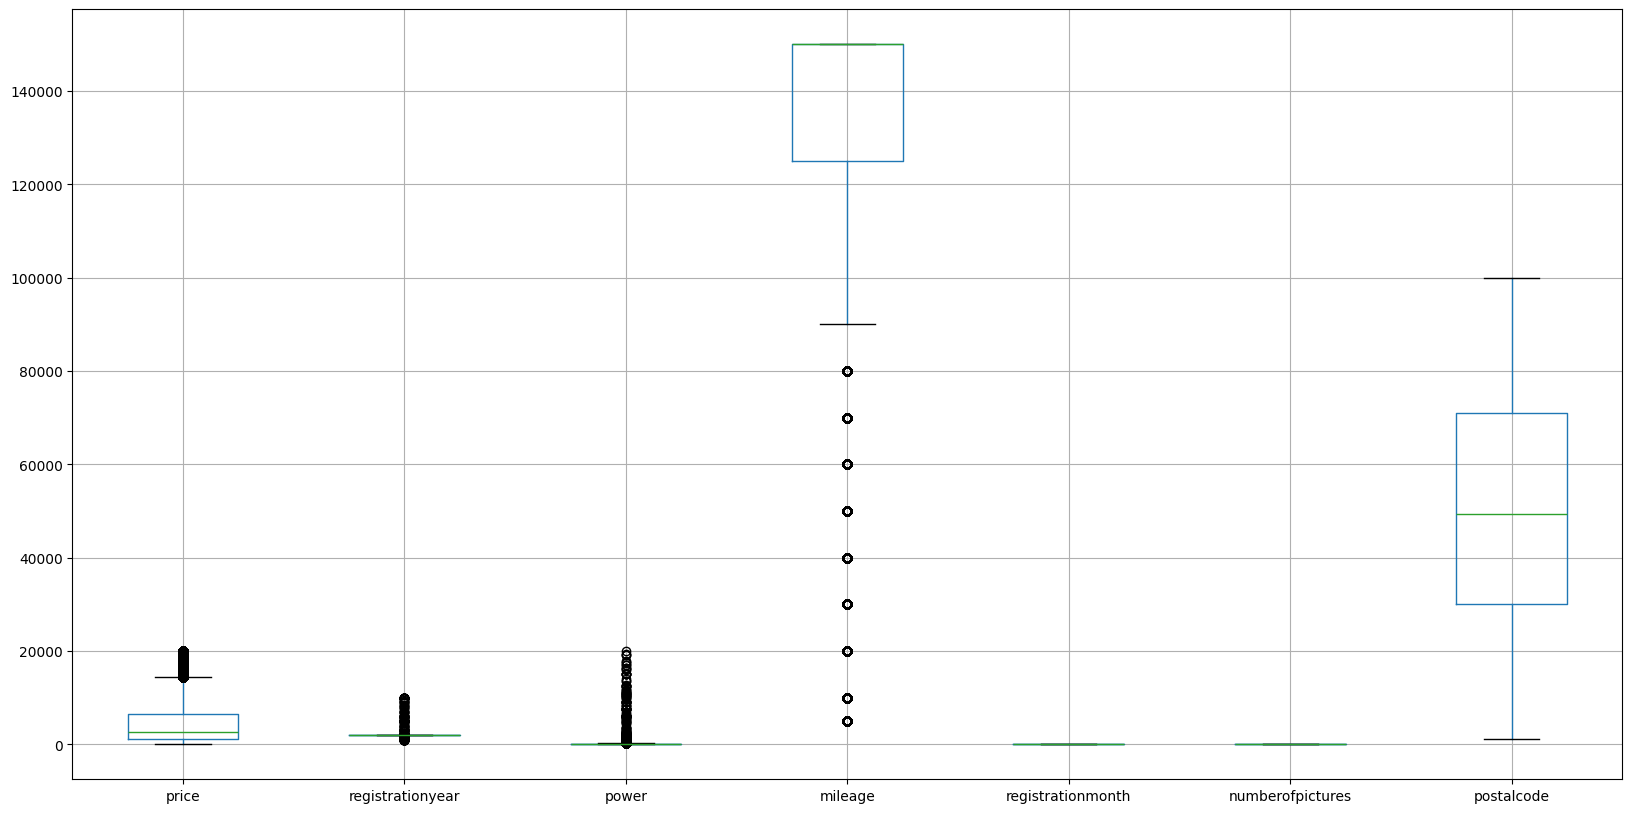

In [6]:
# set the figure size
plt.figure(figsize=(20,10))

# plot a boxplot for all numerical columns
df.boxplot()

# show the plot
plt.show()


In [7]:
# describe the data
df.describe()

,datecrawled,price,registrationyear,power,mileage,registrationmonth,datecreated,numberofpictures,postalcode,lastseen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:57:41.165057280,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:50:30.593703680
min,2016-03-05 14:06:00,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:52:00,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:00
50%,2016-03-21 17:50:00,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:00
75%,2016-03-29 14:37:00,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:00
max,2016-04-07 14:36:00,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:00
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


The numberofpictures column seems to have useless data--every value is 0. We can drop it from our dataframe.

Given that the latest datecreated value is in 2016, it doesn't make sense for the registration year to be greater than 2016. Likewise, it doesn't make much sense for the registration year to be before 1900. We'll address these values.

In [8]:
# drop the numberofpictures column
df.drop('numberofpictures', axis=1, inplace=True)

In [9]:
# replace registrationyear values that aren't null and are greater than 2016 with the median value based on the brand and model
df.loc[(df['registrationyear'].notnull()) & (df['registrationyear'] > 2016), 'registrationyear'] = df.groupby(['brand', 'model'])['registrationyear'].transform('median')

# replace registrationyear values that aren't null and are less than 1900 with the median value based on the brand and model
df.loc[(df['registrationyear'].notnull()) & (df['registrationyear'] < 1900), 'registrationyear'] = df.groupby(['brand', 'model'])['registrationyear'].transform('median')


/var/folders/6k/r1zgzskx1kd7_3xy_n5q44rm0000gn/T/ipykernel_1437/1492199979.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2006. 2008. 2001. ... 2003. 2001. 2001.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['registrationyear'].notnull()) & (df['registrationyear'] > 2016), 'registrationyear'] = df.groupby(['brand', 'model'])['registrationyear'].transform('median')


In [10]:
# count the values of model
print(df['model'].value_counts(ascending=False))

# replace model values of 'other' with NaN values
df['model'] = df['model'].replace('other', np.nan)

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64


There are 24,421 rows where the model is 'other.' That's a lot of data to have vague information for so we'll replace these values with NaN and let our KNNImputer fill them in in the next step instead.

In [11]:
'''Impute missing model values using KNNImputer'''

# select categorical columns
categorical_cols = ['vehicletype', 'gearbox', 'fueltype', 'brand']

# one-hot encode categorical columns using get_dummies
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# replace missing 'model' with NaN (if they are not already NaN values)
df_encoded['model'] = pd.factorize(df['model'])[0]

# combine the encoded catgorical data with the numerical columns in one dataframe
numerical_cols = ['price', 'registrationyear', 'power', 'mileage']
impute_df = pd.concat([df[numerical_cols], df_encoded, df['model']], axis=1)

# initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# perform the imputation
imputed_array = imputer.fit_transform(df_encoded)

# convert the imputed_array back to a dataframe
imputed_df = pd.DataFrame(imputed_array, columns=df_encoded.columns)

# convert the 'model' values in imputed_df back to their original categories
model_labels = pd.factorize(df['model'])[1]
imputed_df['model'] = imputed_df['model'].round().astype(int)
imputed_df['model'] = imputed_df['model'].map(lambda x: model_labels[x] if x < len(model_labels) else None)

# merge back the imputed 'model' values into the original DataFrame
df['model'] = imputed_df['model']


It's challenging to fill in the missing model values based on one or two other features' values alone. We can use a KNN model to impute the missing model values based their nearest 5 neighbors. Let's see how our missing values look now:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   352289 non-null  float64       
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              354369 non-null  object        
 7   mileage            354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  notrepaired        283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  postalcode         354369 non-null  int64   

In [13]:
# get the rows where postalcode is < 5 digits and print them
print(df[df['postalcode'].astype(str).str.len() < 5]['postalcode'])


14        4177
23        9526
36        2943
63        6242
64        1129
          ... 
354311    1217
354337    4107
354348    1217
354353    4275
354364    2694
Name: postalcode, Length: 18159, dtype: int64


There are over 18k rows that have less than 5 digit postal codes. Zip code shouldn't be an input into our model anyway, but we can revisit this field if need be.

In [14]:
# fill missing registration year values with the median value of the brand and model
df['registrationyear'] = df.groupby(['brand', 'model'])['registrationyear'].transform(lambda x: x.fillna(x.median()))

# print the count of rows where the registrationyear is still missing
print(df['registrationyear'].isnull().sum())


0


When we addressed illogical values in the registration year field, we removed some values. We will now fill them in based on the median registration year for a given brand and model.

Now, there are 0 missing registration year values.

In [15]:
# fill missing gearbox values with the mode value based on the brand and model
df['gearbox'] = df.groupby(['brand','model'])['gearbox'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing vehicletype values with the mode value based on the brand and model
df['vehicletype'] = df.groupby(['brand', 'model'])['vehicletype'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing fueltype values with the mode value based on the brand and model
df['fueltype'] = df.groupby(['brand', 'model'])['fueltype'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing datecreated values with the mode value based lastseen and datecrawled values
df['datecreated'] = df.groupby(['lastseen', 'datecrawled'])['datecreated'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing mileage values with the median value based on the brand and model
df['mileage'] = df.groupby(['brand', 'model'])['mileage'].transform(lambda x: x.fillna(x.median()))

# fill missing lastseen values with the mode value based on the datecrawled and datecreated values
df['lastseen'] = df.groupby(['datecrawled', 'datecreated'])['lastseen'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing registrationmonth values with the mode value based on the model values
df['registrationmonth'] = df.groupby(['model'])['registrationmonth'].transform(lambda x: x.fillna(x.mode()[0]))


We can fill in the remaining missing values with the median for mode for a given feature grouped by associated features.

In [16]:
# Group the dataframe by model and count the number of distinct brand values
brand_model_counts = df.groupby('model')['brand'].nunique()

# Filter the brand_model_counts dataframe to get the combinations where the count is greater than 1
brand_model_combinations = brand_model_counts[brand_model_counts > 1]

# display all the rows
pd.set_option('display.max_rows', None)

# Print the brand and model combinations
for model, count in brand_model_combinations.items():
    print(f"Model: {model}, Number of Distinct Brands: {count}")

# print the brand and model combinations for the models 1_reihe, 3_reihe, 5_reihe, defender, discover, freelander, grand, and matiz
for model in ['1_reihe', '3_reihe', '5_reihe', 'defender', 'discovery', 'freelander', 'grand', 'matiz']:
    print(f"Model: {model}, Brands: {df[df['model'] == model]['brand'].unique()}")

# where the model is defender, discovery, or freelander, replace the brand with land_rover
df.loc[df['model'].isin(['defender', 'discovery', 'freelander']), 'brand'] = 'land_rover'


Model: 1_reihe, Number of Distinct Brands: 2
Model: 3_reihe, Number of Distinct Brands: 2
Model: 5_reihe, Number of Distinct Brands: 2
Model: defender, Number of Distinct Brands: 2
Model: discovery, Number of Distinct Brands: 2
Model: freelander, Number of Distinct Brands: 2
Model: grand, Number of Distinct Brands: 3
Model: matiz, Number of Distinct Brands: 2
Model: serie_1, Number of Distinct Brands: 40
Model: 1_reihe, Brands: ['mazda' 'peugeot']
Model: 3_reihe, Brands: ['mazda' 'peugeot']
Model: 5_reihe, Brands: ['mazda' 'peugeot']
Model: defender, Brands: ['land_rover' 'rover']
Model: discovery, Brands: ['land_rover' 'rover']
Model: freelander, Brands: ['land_rover' 'rover']
Model: grand, Brands: ['jeep' 'suzuki' 'chrysler']
Model: matiz, Brands: ['chevrolet' 'daewoo']


There are a few models that have more than 1 distinct associated brand. Most make sense, but we can specify the correct brand for the defender, discovery, and feelander models. 

In [17]:
# convert registrationyear to integer
df['registrationyear'] = df['registrationyear'].astype(int)

The registration year should be an integer datatype instead of a float.

In [18]:
# see the distribution of the notrepaired column
print(df['notrepaired'].value_counts())

# fill missing notrepaired values with 'unknown'
df['notrepaired'] = df['notrepaired'].fillna('unknown')

notrepaired
no     247161
yes     36054
Name: count, dtype: int64


Often, it makes sense to fill missing values for a field with binary values with the mode, but whether a vehicle is repaired or not is very important ot the price and we don't want to make inaccurate assumptions here. We'll fill NaN values with 'other' instead.

In [19]:
# check for duplicates
print(df.duplicated().sum())

# drop duplicates
df.drop_duplicates(inplace=True)

272


There are 271 duplicate values, which may have been a result of some of the data cleaning. We'll drop them since there are very few relative to the size of the dataset.

# Prepare the data for the models

In [20]:
# set the target and features
target = df['price']
features = df.drop(columns=['price','datecreated','registrationmonth','postalcode','datecrawled','lastseen'], axis=1)

# split the data into training and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(features, target, test_size=0.3, random_state=12345)

# further split the testing data into testing data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=12345)


# Linear Regression Model

In [21]:
# initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False) 

# specify the categorical columns for the training and validation sets
categorical_cols_train = X_train[['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']]
categorical_cols_val = X_val[['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']]

# specify the numeric columns for the training set
numeric_cols_train = X_train[['power','registrationyear','mileage']]
numeric_cols_val = X_val[['power','registrationyear','mileage']]

# Fit and transform the data
encoded_cat_train = encoder.fit_transform(categorical_cols_train)
encoded_cat_val = encoder.transform(categorical_cols_val)


# Convert to DataFrame 
encoded_X_train = pd.DataFrame(
    encoded_cat_train, 
    columns=encoder.get_feature_names_out(categorical_cols_train.columns)
)

encoded_X_val = pd.DataFrame(
    encoded_cat_val,
    columns=encoder.get_feature_names_out(categorical_cols_val.columns)
)


# combine the encoded categorical data with the numeric data
encoded_df_X_train = pd.concat([encoded_X_train, numeric_cols_train.reset_index(drop=True)], axis=1)
encoded_df_X_val = pd.concat([encoded_X_val, numeric_cols_val.reset_index(drop=True)], axis=1)

# initialize the StandardScaler
scaler = StandardScaler()

# specify the numeric columns
numeric = ['power','registrationyear','mileage']

# fit the scaler on the training data
scaler.fit(encoded_df_X_train[numeric])

# transform the training and validation data
encoded_df_X_train[numeric] = scaler.transform(encoded_df_X_train[numeric])

# initialize model constructor
model = LinearRegression() 

# train the model, get predictions, and score the predicted targets vs. the actual targets using neg RMSE through cross validation
result = cross_val_score(model, encoded_df_X_train, y_train, scoring='neg_root_mean_squared_error')
neg_result = -result

# calculate the RMSE on the cross-validated predictions and print it
print("RMSE of the linear regression model on the validation set:", neg_result.mean())

RMSE of the linear regression model on the validation set: 2980.8737408591837


#### Get the time required to train the linear regression model

In [22]:
%%time

# initialize model constructor
model = LinearRegression() 

# train the model on the training set
model.fit(encoded_df_X_train, y_train) 
print()


CPU times: user 5.83 s, sys: 354 ms, total: 6.18 s
Wall time: 2.8 s


#### Get the time required to make predictions on the validation set

In [23]:
%%time

# get the predictions on the validation set
y_pred = model.predict(encoded_df_X_val)

CPU times: user 38.7 ms, sys: 23 ms, total: 61.6 ms
Wall time: 46.1 ms


# Random Forest Regressor Model

In [24]:
# initialize the OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder on the training set
encoder.fit(X_train)

# Transform the training set and convert it to a dataframe with the original column names
X_train_ordinal = pd.DataFrame(encoder.transform(X_train), columns=X_train.columns)
X_val_ordinal = pd.DataFrame(encoder.transform(X_val), columns=X_val.columns)


# loop through different values of n_estimators and max_depth
best_result = 5000
for est in range(30, 51, 10):
    for depth in range (7, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # initialize the model
        score_array = cross_val_score(model, X_train_ordinal, y_train, cv=3, scoring='neg_root_mean_squared_error') # calculate the negative RMSE scores from the cross-validated predictions
        neg_result = -score_array # get the positive RMSE scores
        result = neg_result.mean() # get the mean of the positive RMSE scores
        if result < best_result: # if the result is better than the previous best result then update the best result, best_model, best_est, and best_depth variables
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE of the model on the cross-validated predictions:", best_result, "n_estimators:", best_est, "best_depth:", best_depth)

RMSE of the model on the cross-validated predictions: 2039.521627514385 n_estimators: 50 best_depth: 10


#### Get the time required to train the Random Forest Regressor with our tuned hyperparameters from the previous step

In [25]:
%%time 

# initialize the random forest regressor model with the best hyperparameters from the previous step
model = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=10)

# train the model on the training set
model.fit(X_train_ordinal, y_train)
print()



CPU times: user 9.65 s, sys: 42 ms, total: 9.69 s
Wall time: 9.93 s


#### Get the time required to make predictions on the optimized Random Forest Regressor Model

In [26]:
%%time

# get model predictions on the validation set
ypred_test = model.predict(X_val_ordinal)


CPU times: user 134 ms, sys: 2.91 ms, total: 137 ms
Wall time: 137 ms


# CatBoost Regressor Model

In [27]:
# specify the categorical features
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

# define an objective function for Optuna to optimize
def objective(trial):
    # define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.2),
        'depth': trial.suggest_int('depth', 8, 16),
        'random_seed': 12345,
        'early_stopping_rounds': 50,
        'use_best_model': True
    }

    # initialize the CatBoost Regressor
    model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, **params)
    
    # fit the model on the training set and evaluate it on the validation set
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)    
    
    # get the predictions on the validation set
    ypred_val = model.predict(X_val)

    # calculate the RMSE on the validation set
    rmse = mean_squared_error(y_val, ypred_val)**0.5

    # return the RMSE on the validation set
    return rmse


# create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=2400)  # 30 trials or 40 min max

# output the best parameters found by Optuna
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)


[I 2024-11-05 07:12:23,126] A new study created in memory with name: no-name-5e9280ca-08e0-4020-b84a-47d4da2b906f
[I 2024-11-05 07:14:58,680] Trial 0 finished with value: 1709.903305567409 and parameters: {'iterations': 1926, 'learning_rate': 0.11979211073890922, 'depth': 9}. Best is trial 0 with value: 1709.903305567409.
[I 2024-11-05 07:17:08,222] Trial 1 finished with value: 1709.4436122981244 and parameters: {'iterations': 1079, 'learning_rate': 0.11861556942027081, 'depth': 11}. Best is trial 1 with value: 1709.4436122981244.
[I 2024-11-05 07:18:53,257] Trial 2 finished with value: 1719.390025458997 and parameters: {'iterations': 1431, 'learning_rate': 0.16664058510130958, 'depth': 8}. Best is trial 1 with value: 1709.4436122981244.
[I 2024-11-05 07:20:46,017] Trial 3 finished with value: 1717.053034558867 and parameters: {'iterations': 2091, 'learning_rate': 0.18432076409061954, 'depth': 14}. Best is trial 1 with value: 1709.4436122981244.
[I 2024-11-05 07:22:55,376] Trial 4 fini

Best parameters found by Optuna: {'iterations': 2490, 'learning_rate': 0.09666951646998026, 'depth': 13}


#### Get the time it takes to train CatBoost with the best parmeters from the previous step

In [28]:
%%time

model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, iterations=2687, learning_rate=0.04276348758307158, depth=13, random_seed=12345, early_stopping_rounds=50)

# train the model on the training set
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

CPU times: user 32min 55s, sys: 44.7 s, total: 33min 40s
Wall time: 7min 4s


#### Get the time it takes CatBoost to make predictions on the validation set

In [29]:
%%time

model.predict(X_val)

CPU times: user 1.9 s, sys: 91.3 ms, total: 1.99 s
Wall time: 415 ms


array([7746.33236723, 5844.15202447, 3297.17313275, ..., 2772.50423576,
       1922.71363669, 1707.14692162])

# XGBoost Model

In [30]:
# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [7, 10],
    'subsample': [0.8, 1.0]
}

# initialize the XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)

# initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

# fit the model using grid search
grid_search.fit(encoded_df_X_train, y_train)

# print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {(-grid_search.best_score_) ** 0.5}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Best RMSE: 1741.1887497252371


#### Get the time required to train the XGBoost model using the best hyperparameter values from the previous step

In [31]:
%%time

# initialize the LGBM Regressor
model = lgb.LGBMRegressor(random_state=12345, n_estimators=500, learning_rate=0.1, max_depth=10, subsample=0.8)

# train the model on the training set
model.fit(encoded_df_X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 247867, number of used features: 295
[LightGBM] [Info] Start training from score 4421.965724
CPU times: user 5.02 s, sys: 3.47 s, total: 8.49 s
Wall time: 3.26 s


LGBMRegressor(max_depth=10, n_estimators=500, random_state=12345, subsample=0.8)

#### Get the time required to make predictions on the validation set

In [32]:
%%time

ypred_val = model.predict(encoded_df_X_val)

CPU times: user 1.74 s, sys: 37.8 ms, total: 1.78 s
Wall time: 321 ms


# LightGBM Model

In [33]:

# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 300],
    'learning_rate': [0.01, 0.2],
    'max_depth': [15],
    'num_leaves': [50, 100]
}

# convert categorical columns to appropriate data types
X_train['vehicletype'] = X_train['vehicletype'].astype('category')
X_train['gearbox'] = X_train['gearbox'].astype('category')
X_train['model'] = X_train['model'].astype('category')
X_train['fueltype'] = X_train['fueltype'].astype('category')
X_train['brand'] = X_train['brand'].astype('category')
X_train['notrepaired'] = X_train['notrepaired'].astype('category')

# initialize the LightGBM Regressor
model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=12345, verbose=-1)

# initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

# fit the model using grid search
grid_search.fit(X_train, y_train, categorical_feature=cat_features)

# print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {(-grid_search.best_score_) ** 0.5}")


Best parameters: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 100}
Best RMSE: 1736.4737745414427


#### Ensure the features are the same in the training and validation sets

In [34]:
# ensure X_val has the same columns as X_train
missing_cols = set(X_train.columns) - set(X_val.columns)

# Create the columns with a value of 0 if they don't exist
for col in missing_cols:
    X_val[col] = 0

# convert categorical columns to appropriate data types
X_val['vehicletype'] = X_val['vehicletype'].astype('category')
X_val['gearbox'] = X_val['gearbox'].astype('category')
X_val['model'] = X_val['model'].astype('category')
X_val['fueltype'] = X_val['fueltype'].astype('category')
X_val['brand'] = X_val['brand'].astype('category')
X_val['notrepaired'] = X_val['notrepaired'].astype('category')


#### Get the time required to train the LightGBM model

In [35]:
%%time

# initialize the LightGBM Regressor with the best hyperparameters from the previous step
model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=12345, verbose=-1, 
                          n_estimators=300, learning_rate=0.2, max_depth=15, num_leaves=100)

# train the model on the training set
model.fit(X_train, y_train, categorical_feature=cat_features)
print()


CPU times: user 3.34 s, sys: 5.19 s, total: 8.53 s
Wall time: 3.74 s


#### Get the time required to make predictions on the validation set

In [36]:
%%time

# get model predictions on the validation set
ypred_val = model.predict(X_val)

CPU times: user 1.04 s, sys: 19.7 ms, total: 1.06 s
Wall time: 173 ms


Overall, Catboost achieved the best RMSE score of 1,700, however the scores of all three gradient boosting models performed very similarly. The LightGBM model had a RMSE of 1,736 while XGBoost had a RMSE of 1,741. 

However, since Rusty Bargain cares about the speed of the model training process and the time it takes to generate predictions in addition to the model performance, LightGBM performs the best in terms of the time to train the model (a wall time of 1.77 seconds) and the time to make predictions (a wall time of 161 milliseconds). Our best performing model, CatBoost, took over 6 minutes to train the model. XGBoost took a wall time of 2.84 seconds to train the model.

We will select LightGBM as the best model for Rusty Bargain given its balance of performance and speed.

# Make predictions on the test set with the best model

In [37]:
# initialize the LightGBM Regressor with the best hyperparameters from the previous step
model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=12345, verbose=-1, 
                          n_estimators=300, learning_rate=0.2, max_depth=15, num_leaves=100)

# train the model on the training set
model.fit(X_train, y_train, categorical_feature=cat_features)
print()

# ensure X_test has the same columns as X_train
missing_cols = set(X_train.columns) - set(X_test.columns)

# Create the columns with a value of 0 if they don't exist
for col in missing_cols:
    X_test[col] = 0

# convert categorical columns to appropriate data types
X_test['vehicletype'] = X_test['vehicletype'].astype('category')
X_test['gearbox'] = X_test['gearbox'].astype('category')
X_test['model'] = X_test['model'].astype('category')
X_test['fueltype'] = X_test['fueltype'].astype('category')
X_test['brand'] = X_test['brand'].astype('category')
X_test['notrepaired'] = X_test['notrepaired'].astype('category')

# get model predictions on the testing set
ypred_test = model.predict(X_test)

# calculate the RMSE on the testing set
rmse = mean_squared_error(y_test, ypred_test)**0.5

# print the RMSE on the testing set
print("RMSE on the testing set:", rmse)


RMSE on the testing set: 1709.4629694387668


# Project Conclusion

Our testing set performed slightly better than our validation set with an RMSE of 1,709! This means that the LightGBM model is, on average, able to predict the value of a vehicle with accuracy within a range of $1,709.46 dollars.

Our linear regression model was expected to perform the worst for Rusty Bargain's need and hence serves as a solid sanity check against the performance of our other models. The linear regression model achieved a RMSE of 2,980 so our other model are certainly an improvement. Lastly, our Random Forest Regressor model achieved a RMSE of 2,039, which was a solid improvement over linear regression, yet not as strong as our gradient boosting models (as expected).